In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [2]:
import re

In [3]:
from textblob import TextBlob
 
a = "aannndd"           # incorrect spelling
print("original text: "+str(a))
 
b = TextBlob(a)
 
# prints the corrected spelling
print("corrected text: "+str(b.correct()))

original text: aannndd
corrected text: aannndd


# Exploratory Data Analysis

In [4]:
# Import data
data = pd.read_csv('dataset_sms_spam_v1.csv')

In [5]:
data.head()

,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2


In [6]:
# Definisikan kamus untuk label
kamus = {0: 'sms normal'
,1: 'fraud atau penipuan',
2: 'promo'}

data['Sentiment'] = data.label.apply(lambda x: kamus.get(x))

In [7]:
data.head()

,Teks,label,Sentiment
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2,promo
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2,promo
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2,promo
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2,promo
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2,promo


In [8]:
data.shape

(1143, 3)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Teks       1143 non-null   object
 1   label      1143 non-null   int64 
 2   Sentiment  1143 non-null   object
dtypes: int64(1), object(2)
memory usage: 26.9+ KB


Tidak ada null values

In [10]:
data.describe()

,label
count,1143.000000
mean,0.711286
std,0.790001
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,2.000000


## Jumlah Sentiment

In [11]:
# Menghitung jumlah sentiment untuk tiap kategori
cm = sns.light_palette("green", as_cmap=True)
sent_count = data.groupby('Sentiment')['Teks'].count().reset_index().sort_values(by = 'Teks', ascending = False)
sent_count.style.background_gradient(cmap = 'Purples')

,Sentiment,Teks
2,sms normal,569
0,fraud atau penipuan,335
1,promo,239


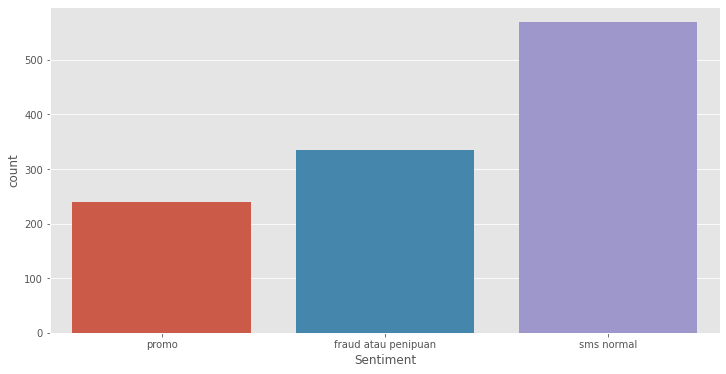

In [12]:
plt.figure(figsize = (12, 6))
sns.countplot(x = 'Sentiment', data = data)
plt.show()

## Jumlah Huruf

In [13]:
def char_count(sentence):
  sentence = sentence.replace(" ","")
  return len(sentence)

data['char_count'] = data['Teks'].apply(char_count)

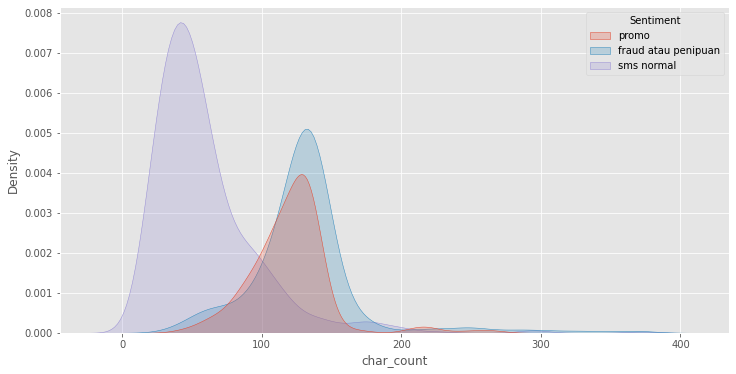

In [14]:
plt.figure(figsize = (12,6))
sns.kdeplot(x = 'char_count', hue = 'Sentiment', shade = True, data = data)
plt.show()

Rata-rata sentiment yang berbau penipuan memiliki 100-200 huruf

In [15]:
data['char_count'].describe().to_frame()

,char_count
count,1143.000000
mean,92.974628
std,51.178256
min,10.000000
25%,49.000000
50%,95.000000
75%,130.000000
max,373.000000


Paling sedikit terdapat 13 huruf sementara paling banyak terdapat 434 huruf. Rata-rata huruf yang digunakan ada 109 huruf

## Jumlah Kata

In [16]:
def word_count(sentence):
  sentence = sentence.split()
  return len(sentence)

data['word_count'] = data['Teks'].apply(word_count)

In [17]:
data.head()

,Teks,label,Sentiment,char_count,word_count
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2,promo,127,26
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2,promo,128,25
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2,promo,132,21
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2,promo,133,21
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2,promo,96,18


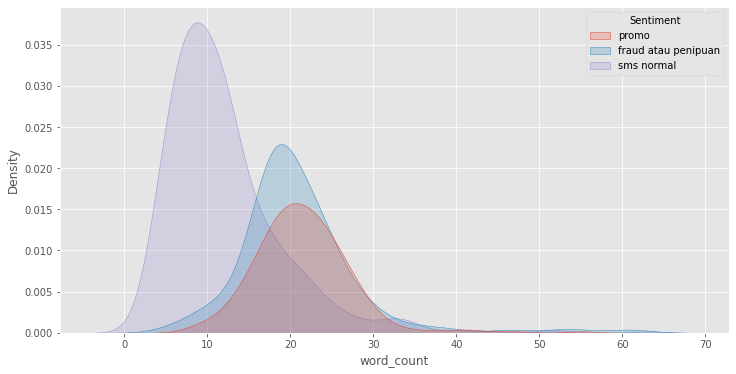

In [18]:
plt.figure(figsize = (12,6))
sns.kdeplot(x = 'word_count', hue = 'Sentiment', shade = True, data = data)
plt.show()

Bisa dilihat terdapat perbedaan yang mencolok antara sentiment berbau fraud, promo dan sms normal

In [19]:
data['word_count'].describe().to_frame()

,word_count
count,1143.000000
mean,16.687664
std,8.439519
min,2.000000
25%,10.000000
50%,17.000000
75%,22.000000
max,63.000000


Minimal kata yang digunakan ada 2 kata, maksimal terdapat 63 kata, rata-rata terdapat 17 kata

# Text Cleaning

In [49]:
!pip install PySastrawi

     |████████████████████████████████| 210 kB 5.2 MB/s 


In [20]:
import re

In [21]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from spacy.lang.id.stop_words import STOP_WORDS
from collections import Counter

In [22]:
data[data["Sentiment"] == "fraud atau penipuan"]

,Teks,label,Sentiment,char_count,word_count
239,"Jika anda bermasalah dgn CC/KT@, stres dgn bun...",1,fraud atau penipuan,104,16
240,"Lelah byr min payment? Kami Solusinya, bantu s...",1,fraud atau penipuan,121,17
241,"Dana Tunai (KTA) bunga 0,99% hingga 300 jt. Sy...",1,fraud atau penipuan,123,28
242,“ROXI CELL” Hanya dengan Rp.100rb Anda bisa ja...,1,fraud atau penipuan,139,21
243,3 RAMADHAN Selamat Anda Pemenang Rp.100jt. PIN...,1,fraud atau penipuan,90,11
...,...,...,...,...,...
569,Yth Bpk/Ibu. BNI menyatakan Rekening anda terp...,1,fraud atau penipuan,128,19
570,Yth Isti Sofiyah. Diminta Segera Hubungi Bpk D...,1,fraud atau penipuan,129,23
571,YTH kpd bpk/ibu sy Eka Novitasari kariyawan 3c...,1,fraud atau penipuan,285,49
572,"YTH,MIitra Silahkan cek poin anda dan tukarkan...",1,fraud atau penipuan,89,16


In [23]:
data['Teks'][243]

'3 RAMADHAN Selamat Anda Pemenang Rp.100jt. PIN CODE 7Y7R8K9Z Info: www.hadiah-3ramadhan.blogspot.com   '

In [24]:
data['Teks'][2]

'2016-07-08 11:47:11.Plg Yth, sisa kuota Flash Anda 478KB. Download MyTelkomsel apps di http://tsel.me/tsel utk cek kuota&beli paket Flash atau hub *363#'

In [25]:
data.Teks[1136]

'Yg ragu sm bulet/datar atau yg pgn ikutan debat kusir :v'

In [26]:
data.head()

,Teks,label,Sentiment,char_count,word_count
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2,promo,127,26
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2,promo,128,25
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2,promo,132,21
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2,promo,133,21
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2,promo,96,18


In [27]:
data.Teks[0]

'[PROMO] Beli paket Flash mulai 1GB di MY TELKOMSEL APP dpt EXTRA kuota 2GB 4G LTE dan EXTRA nelpon hingga 100mnt/1hr. Buruan, cek  di tsel.me/mytsel1 S&K'

In [28]:
kalimat = data.Teks.iloc[1].lower()

In [29]:
kalimat

'2.5 gb/30 hari hanya rp 35 ribu spesial buat anda yang terpilih. aktifkan sekarang juga di *550*905#. promo sd 30 nov 2015.buruan aktifkan sekarang. s&k'

In [30]:
kal_baru = re.sub(r'\w*\.*\w{1,}\.*\/\w{1,}','',kalimat)
kal_baru

'2.5  hari hanya rp 35 ribu spesial buat anda yang terpilih. aktifkan sekarang juga di *550*905#. promo sd 30 nov 2015.buruan aktifkan sekarang. s&k'

In [31]:
def bersih_bersih(sentence):
  '''Membuat kalimat menjadi huruf kecil semua, menghilangkan clickbait seperti [PROMO], tanggal di awal SMS, jumlah tarif, pulsa'''

  sentence = sentence.lower()
  sentence = re.sub(r'(\[.*?\]|\(.*?\))','',sentence) #menghilangkan kata-kata dalam kurung 

  sentence = re.sub(r'\d{4}-\d{2}-\d{2}\s\d{2}:\d{2}:\d{2}\.','',sentence) #menghilangkan format tanggal dan waktu
  sentence = re.sub(r'\d{2}\s\w{3,}\s\d{4}.','', sentence) #Menghilangkan format tanggal "XX NAMA BULAN TAHUN"

  sentence = re.sub(r'(menit|mnt|thn|tahun|minggu|mg|hari|hr|jam|jm|detik|dtk|sekon)*','', sentence) #Menghilangkan satuan waktu
  sentence = re.sub(r'(\d{1,}\s*gb|\d{1,}\s*kb|\d{1,}\s*mb|\d{1,}\s*tb|lte)',"", sentence) #Menghilangkan satuan byte dan kata lte
  sentence = re.sub(r'(ribu|rb|jt|juta|milyar|miliar|triliun|trilyun)',"", sentence) # Menghilangkan satuan uang

  sentence = re.sub(r'\w*\.*\w{1,}\.*\/\w{1,}','',sentence) #Menghilangkan pecahan
  sentence = re.sub(r'rp\s*\d{1,}\s','',sentence) # Menghilangkan jumlah tarif

  sentence = re.sub(r"\*\d{3,}\*\d{3,}\#","", sentence) # Menghilangkan kode aktivasi-1
  sentence = re.sub(r"\*\d{3,}\#","", sentence) #Menghilangkan kode aktivasi-2

  sentence = re.sub(r"https?://\S*|www\.\S+","", sentence) #Menghilangkan web
  sentence = re.sub(r'(\d{1,}\.*\d{0,})','', sentence) #Menghilangkan angka 
  sentence = sentence.strip()

  return sentence


In [32]:
data['Teks Bersih'] = data['Teks'].apply(bersih_bersih)

In [33]:
data[['Teks','Teks Bersih']]

,Teks,Teks Bersih
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,beli paket flash mulai di my telkomsel app dp...
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,hanya spesial buat anda yang terpilih. aktifk...
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...","plg yth, sisa kuota flash anda . download myte..."
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...","plg yth, sisa kuota flash anda . download myte..."
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,hanya spesial buat anda yang terpilih. aktifk...
...,...,...
1138,"Yooo sama2, oke nanti aku umumin di grup kelas","yooo sama, oke nanti aku umumin di grup kelas"
1139,😁 sebelumnya ga ad nulis kerudung. Kirain warn...,😁 sebelumnya ga ad nulis kerudung. kirain warn...
1140,Mba mau kirim 300 ya,mba mau kirim ya
1141,nama1 beaok bwrangkat pagi...mau cas atay tra...,nama beaok bwrangkat pagi...mau cas atay tran...


In [34]:
data.Teks[0
          ]

'[PROMO] Beli paket Flash mulai 1GB di MY TELKOMSEL APP dpt EXTRA kuota 2GB 4G LTE dan EXTRA nelpon hingga 100mnt/1hr. Buruan, cek  di tsel.me/mytsel1 S&K'

In [35]:
data.tail(10)

,Teks,label,Sentiment,char_count,word_count,Teks Bersih
1133,Yg butuh kosan perbulan bisa langsung ditempat...,0,sms normal,190,33,yg butuh kosan peulan bisa langsung ditempatin...
1134,"Yg dian ge waktu itu yudisium akhirnya sore2, ...",0,sms normal,92,18,"yg dian ge waktu itu yudisium akhirnya sore, g..."
1135,Yg mau ngampus aku pengen titip bawain SKL aku...,0,sms normal,46,11,yg mau ngampus aku pengen titip bawain skl aku...
1136,Yg ragu sm bulet/datar atau yg pgn ikutan deba...,0,sms normal,46,11,yg ragu sm atau yg pgn ikutan debat kusir :v
1137,Yg sebelah warteg bahri apa sebrangnya? Yg 15,0,sms normal,38,8,yg sebelah warteg bai apa sebrangnya? yg
1138,"Yooo sama2, oke nanti aku umumin di grup kelas",0,sms normal,38,9,"yooo sama, oke nanti aku umumin di grup kelas"
1139,😁 sebelumnya ga ad nulis kerudung. Kirain warn...,0,sms normal,44,9,😁 sebelumnya ga ad nulis kerudung. kirain warn...
1140,Mba mau kirim 300 ya,0,sms normal,16,5,mba mau kirim ya
1141,nama1 beaok bwrangkat pagi...mau cas atay tra...,0,sms normal,44,7,nama beaok bwrangkat pagi...mau cas atay tran...
1142,No bri atas nama kamu mana,0,sms normal,21,6,no bri atas nama kamu mana


In [36]:
data["Teks Bersih"][240]

'lelah byr min payment? kami solusinya, bantu secara legal penutupan , dscn -%. hub.lolyta  . legal'

## Remove Stopwords

In [37]:
import spacy
nlp = spacy.blank('id')

In [41]:
from spacy.lang.id.stop_words import STOP_WORDS
STOP_WORDS.update(['yg','jg','teh','mah','da','atuh','jd','km','ak','lg','ya','ga','ngga','nggak','gak','tp',
                   'kalo','nya','pake','liat','udh','aja','wkwk','wkwkwk','wk','gt','gais','blm','sih','tau',
                   'tahu','gt','udah','utk','rb','rp','dgn','ayo','isi','biar','yah','dr','bawa','gitu','eh',
                   'pas','td','sm','pengen','pgn','dpt','sd','byr','min','dscn','sy'])

In [42]:
def remove_stopwords(sentence):
  words = sentence.split()
  words = [word for word in words if word not in STOP_WORDS and word.isalpha()]
  return " ".join(words)

In [43]:
data['Teks Bersih'] = data['Teks Bersih'].apply(remove_stopwords)

In [44]:
data[['Teks','Teks Bersih']]

,Teks,Teks Bersih
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,beli paket flash my telkomsel app extra kuota ...
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,spesial aktifkan promo buruan aktifkan
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",plg sisa kuota flash download mytelkomsel apps...
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",plg sisa kuota flash download mytelkomsel apps...
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,spesial aktifkan skb
...,...,...
1138,"Yooo sama2, oke nanti aku umumin di grup kelas",yooo oke umumin grup kelas
1139,😁 sebelumnya ga ad nulis kerudung. Kirain warn...,ad nulis kirain warna jins
1140,Mba mau kirim 300 ya,mba kirim
1141,nama1 beaok bwrangkat pagi...mau cas atay tra...,nama beaok bwrangkat cas atay


In [45]:
data['Teks'][240]

'Lelah byr min payment? Kami Solusinya, bantu secara LEGAL penutupan CC/KTA, dscn 50-75%. Hub.LoLyta 081316523061/087822962308 (WA). LEGAL'

In [46]:
data['Teks Bersih'][243]

'ramadhan selamat pemenang pin code yrkz'

## Lemmatizer

In [50]:
# import StemmerFactory class
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [51]:
def lemmatizer(sentence):
  output = stemmer.stem(sentence)
  return output

data['Teks Bersih'] = data['Teks Bersih'].apply(lemmatizer)

In [52]:
data.head()

,Teks,label,Sentiment,char_count,word_count,Teks Bersih
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2,promo,127,26,beli paket flash my telkomsel app extra kuota ...
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2,promo,128,25,spesial aktif promo buru aktif
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2,promo,132,21,plg sisa kuota flash download mytelkomsel apps...
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2,promo,133,21,plg sisa kuota flash download mytelkomsel apps...
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2,promo,96,18,spesial aktif skb


In [53]:
data.tail(10)

,Teks,label,Sentiment,char_count,word_count,Teks Bersih
1133,Yg butuh kosan perbulan bisa langsung ditempat...,0,sms normal,190,33,butuh kosan peulan langsung lokasi gang sampin...
1134,"Yg dian ge waktu itu yudisium akhirnya sore2, ...",0,sms normal,92,18,dian ge yudisium dibarengin nondik sampe yudisium
1135,Yg mau ngampus aku pengen titip bawain SKL aku...,0,sms normal,46,11,ngampus titip bawain skl
1136,Yg ragu sm bulet/datar atau yg pgn ikutan deba...,0,sms normal,46,11,ragu ikut debat kusir
1137,Yg sebelah warteg bahri apa sebrangnya? Yg 15,0,sms normal,38,8,belah warteg bai
1138,"Yooo sama2, oke nanti aku umumin di grup kelas",0,sms normal,38,9,yooo oke umumin grup kelas
1139,😁 sebelumnya ga ad nulis kerudung. Kirain warn...,0,sms normal,44,9,ad nulis kirain warna jins
1140,Mba mau kirim 300 ya,0,sms normal,16,5,mba kirim
1141,nama1 beaok bwrangkat pagi...mau cas atay tra...,0,sms normal,44,7,nama beaok bwrangkat cas atay
1142,No bri atas nama kamu mana,0,sms normal,21,6,no bri nama


In [54]:
data['Teks Bersih'][243]

'ramadhan selamat menang pin code yrkz'

## Frekuensi Kata

Setelah ini akan dilihat frekuensi kata dari data teks bersih untuk setiap kategori

In [55]:
import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize
from nltk import ngrams

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [56]:
def word_frequency(sentence):
  sentence = " ".join(sentence)
  new_tokens = word_tokenize(sentence)
  counted = Counter(new_tokens)
  word_freq = pd.DataFrame(counted.items(), columns = ['Kata','Frekuensi']).sort_values(by = 'Frekuensi',ascending = False)
  return word_freq

In [57]:
from wordcloud import WordCloud
import numpy as np

def wordcloud(sentence, title):
  sentence = " ".join(sentence)
  WC = WordCloud(background_color = 'white', max_words= 500, max_font_size = 100)
  cloud = WC.generate(sentence)
  plt.imshow(cloud, interpolation = "bilinear")
  plt.title(title)
  plt.axis("off")
  plt.show()

In [58]:
data.head()

,Teks,label,Sentiment,char_count,word_count,Teks Bersih
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2,promo,127,26,beli paket flash my telkomsel app extra kuota ...
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2,promo,128,25,spesial aktif promo buru aktif
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2,promo,132,21,plg sisa kuota flash download mytelkomsel apps...
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2,promo,133,21,plg sisa kuota flash download mytelkomsel apps...
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2,promo,96,18,spesial aktif skb


In [59]:
data['Sentiment'].unique()

array(['promo', 'fraud atau penipuan', 'sms normal'], dtype=object)

In [60]:
promos = data[data['Sentiment'] == 'promo'].reset_index().drop('index',axis = 1)
sms_normal = data[data['Sentiment'] == 'sms normal'].reset_index().drop('index',axis = 1)
fraud = data[data['Sentiment'] == 'fraud atau penipuan'].reset_index().drop('index',axis = 1)


In [61]:
promos.head()

,Teks,label,Sentiment,char_count,word_count,Teks Bersih
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2,promo,127,26,beli paket flash my telkomsel app extra kuota ...
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2,promo,128,25,spesial aktif promo buru aktif
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2,promo,132,21,plg sisa kuota flash download mytelkomsel apps...
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2,promo,133,21,plg sisa kuota flash download mytelkomsel apps...
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2,promo,96,18,spesial aktif skb


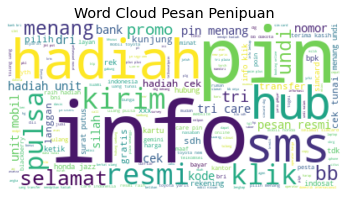

In [62]:
wordcloud(fraud['Teks Bersih'], 'Word Cloud Pesan Penipuan')

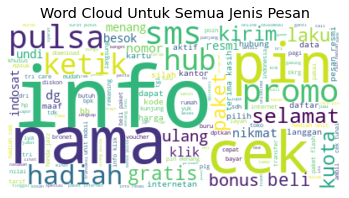

In [63]:
wordcloud(data['Teks Bersih'], "Word Cloud Untuk Semua Jenis Pesan")

In [64]:
semua_senti_20 = word_frequency(data['Teks Bersih'])[:20]

In [65]:
semua_senti_20
semua_senti_20.style.background_gradient(cmap = 'BuGn')

,Kata,Frekuensi
70,info,125
302,hadiah,119
525,pin,102
10,cek,98
62,sms,94
1,paket,93
415,no,87
128,nama,86
23,pulsa,85
110,menang,77


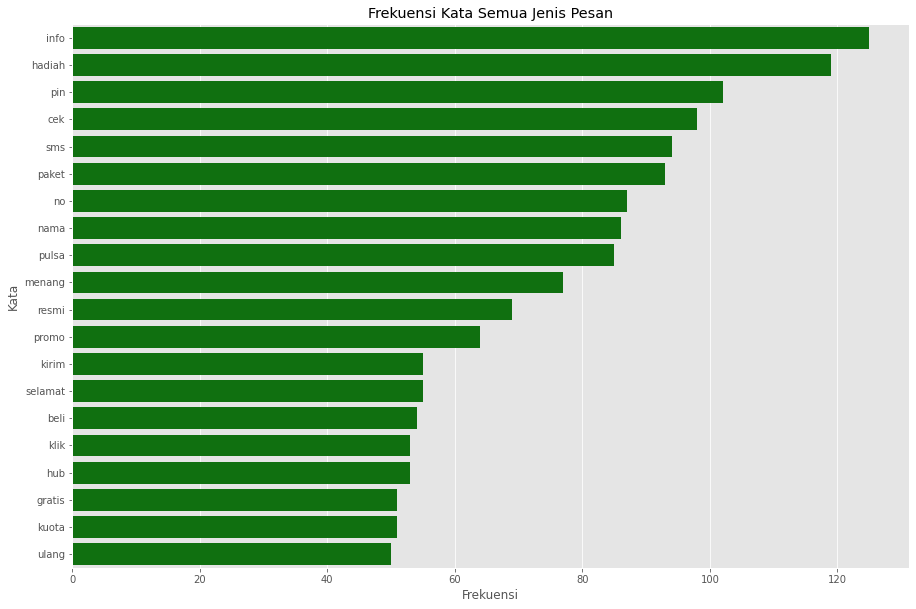

In [66]:
plt.figure(figsize = (15,10))
sns.barplot(x = 'Frekuensi', y = 'Kata', data = semua_senti_20, color = 'green')
plt.title("Frekuensi Kata Semua Jenis Pesan")
plt.show()

In [67]:
sms_normal.head()

,Teks,label,Sentiment,char_count,word_count,Teks Bersih
0,Di kfc yg deket enhaii ada dy,0,sms normal,23,7,kfc deket enhaii dy
1,"Maaf jika ada janji yang belum terpenuhi, jik...",0,sms normal,69,13,maaf janji janji
2,*ngsih bunga ato coklat min,0,sms normal,23,5,bunga ato coklat
3,.sambl nunggu itu.. Gimana kalo ngerjain form ...,0,sms normal,53,10,nunggu gimana ngerjain form formnya
4,[Akademik] Untuk perhatian tuk jadwal kontrak ...,0,sms normal,293,52,perhati tuk jadwal kontrak kuliah ang kuliah j...


In [68]:
fraud.head()

,Teks,label,Sentiment,char_count,word_count,Teks Bersih
0,"Jika anda bermasalah dgn CC/KT@, stres dgn bun...",1,fraud atau penipuan,104,16,masalah stres lunas disc aty legal
1,"Lelah byr min payment? Kami Solusinya, bantu s...",1,fraud atau penipuan,121,17,lelah bantu legal tutup legal
2,"Dana Tunai (KTA) bunga 0,99% hingga 300 jt. Sy...",1,fraud atau penipuan,123,28,dana tunai bunga syarat ktp bpkb rate cair hub...
3,“ROXI CELL” Hanya dengan Rp.100rb Anda bisa ja...,1,fraud atau penipuan,139,21,agen pulsa elektrik operator daftar ketik mtro...
4,3 RAMADHAN Selamat Anda Pemenang Rp.100jt. PIN...,1,fraud atau penipuan,90,11,ramadhan selamat menang pin code yrkz


In [69]:
top_20_kata_promo = word_frequency(promos['Teks Bersih'])[:20]
top_20_kata_fraud = word_frequency(fraud['Teks Bersih'])[:20]
top_20_kata_sms_normal = word_frequency(sms_normal['Teks Bersih'])[:20]

In [70]:
top_20_kata_fraud
top_20_kata_fraud.style.background_gradient(cmap = 'Reds')

,Kata,Frekuensi
151,hadiah,117
32,pin,98
93,info,85
53,no,83
31,menang,73
211,resmi,69
154,cek,50
216,klik,48
381,care,47
138,tri,46


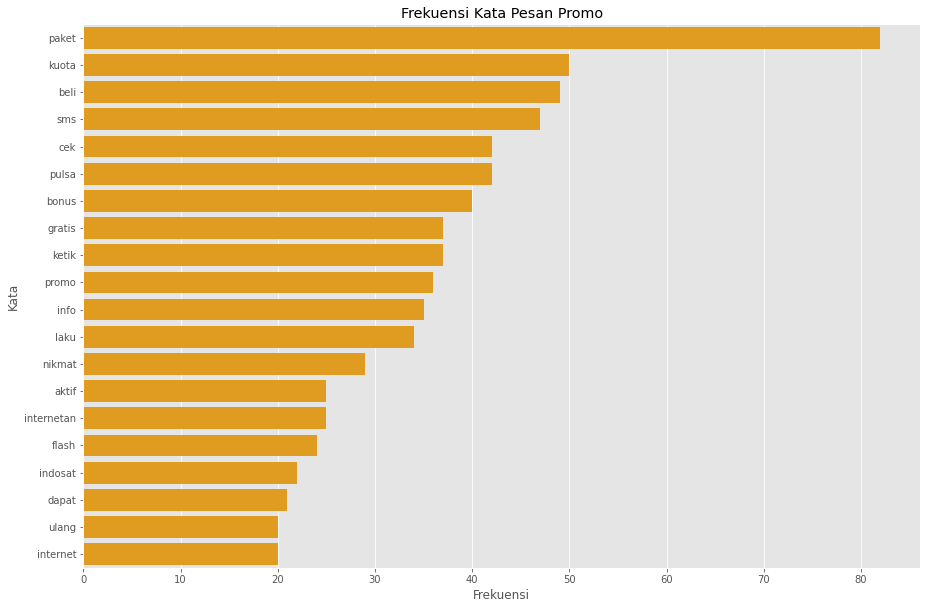

In [71]:
plt.figure(figsize = (15,10))
sns.barplot(x = 'Frekuensi', y = 'Kata', data = top_20_kata_promo, color = 'orange')
plt.title("Frekuensi Kata Pesan Promo")
plt.show()

Kata-kata yang sering muncul pada pesan promo adalah kata paket, kuota, sms, cek, pulsa, dan kata-kata yang berkaitan dengan tawaran promo pulsa ataupun internet oleh provider

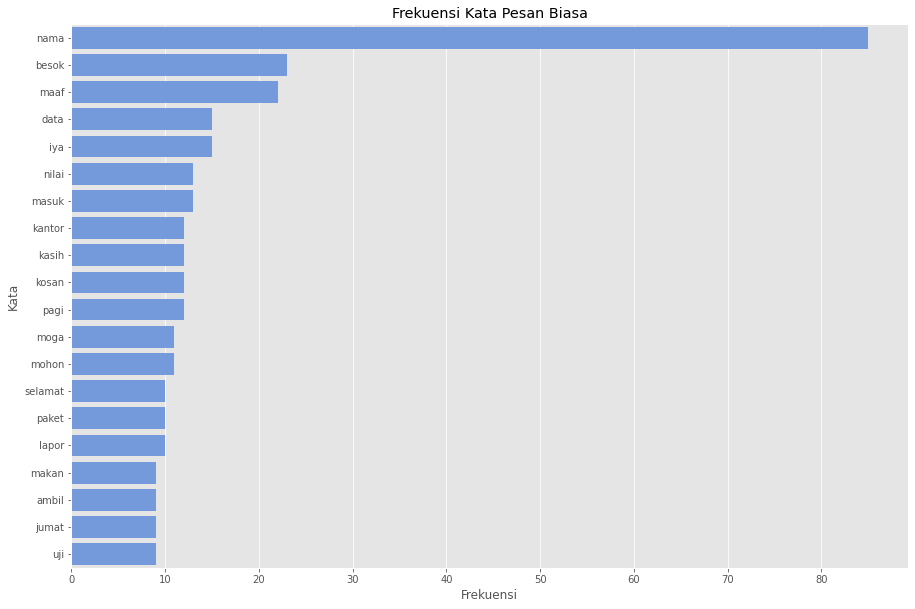

In [72]:
plt.figure(figsize = (15,10))
sns.barplot(x = 'Frekuensi', y = 'Kata', data = top_20_kata_sms_normal, color = 'cornflowerblue')
plt.title("Frekuensi Kata Pesan Biasa")
plt.show()

Karena SMS sering menggunakan percakapan dengan kata yang dipersingkat maka kata-kata teratas adalah kata-kata yang menjadi singkatan dari yang sebenarnya

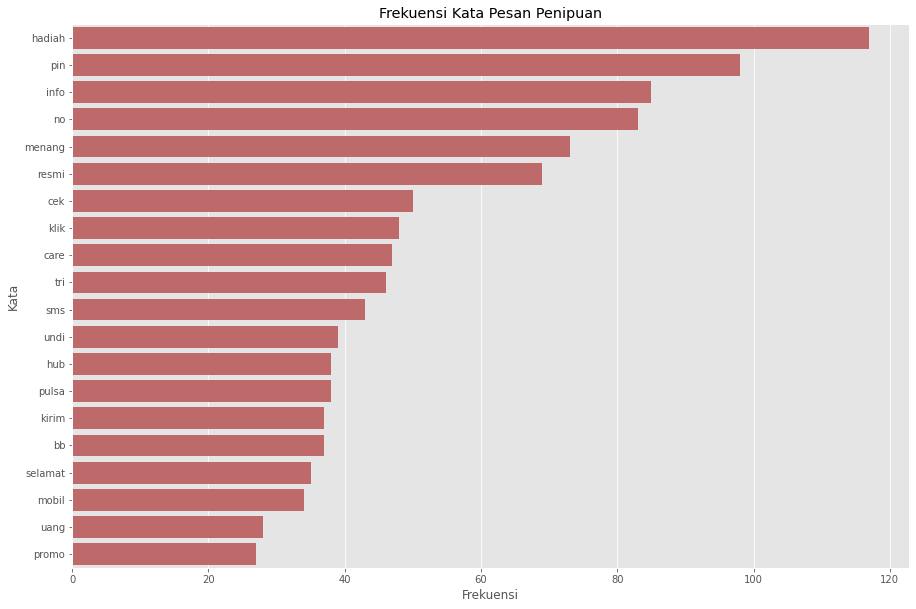

In [73]:
plt.figure(figsize = (15,10))
sns.barplot(x = 'Frekuensi', y = 'Kata', data = top_20_kata_fraud, color = 'indianred')
plt.title("Frekuensi Kata Pesan Penipuan")
plt.show()

Kata-kata yang sering muncul dalam pesan penipuan adalah hadiah, pin, info, pemenang serta benda-benda mewah seperti mobil, uang jutaan, dan lain-lain

# Text Prediction

Akan dilakukan prediksi sentiment dengan data teks yang telah dibersihkan, percobaan pertama akan menggunakan model ML seperti Logistic Regression, Naive Bayes dan Linear SVC. Untuk vectorizernya akan digunakan TfidfVectorizer

## Logistic Regression

In [74]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler,MinMaxScaler,FunctionTransformer
from sklearn.naive_bayes import MultinomialNB

In [75]:
data.head()

,Teks,label,Sentiment,char_count,word_count,Teks Bersih
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2,promo,127,26,beli paket flash my telkomsel app extra kuota ...
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2,promo,128,25,spesial aktif promo buru aktif
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2,promo,132,21,plg sisa kuota flash download mytelkomsel apps...
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2,promo,133,21,plg sisa kuota flash download mytelkomsel apps...
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2,promo,96,18,spesial aktif skb


In [76]:
data['avg_word_length'] = data['char_count']/data['word_count']

In [77]:
data.drop(['Teks','Sentiment','char_count','word_count'], axis = 1, inplace = True)

In [78]:
data.head()

,label,Teks Bersih,avg_word_length
0,2,beli paket flash my telkomsel app extra kuota ...,4.884615
1,2,spesial aktif promo buru aktif,5.120000
2,2,plg sisa kuota flash download mytelkomsel apps...,6.285714
3,2,plg sisa kuota flash download mytelkomsel apps...,6.333333
4,2,spesial aktif skb,5.333333


In [79]:
data.columns

Index(['label', 'Teks Bersih', 'avg_word_length'], dtype='object')

In [80]:
X = data.drop('label',axis = 1)
y = data['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 111, stratify = y)

In [81]:
#Buat fungsi untuk mengambil data bertipe teks
get_text_data = FunctionTransformer(lambda x: x['Teks Bersih'], validate = False)

# Buat fungsi untuk mengambil data bertipe numerik
get_numeric_data = FunctionTransformer(lambda x: x[['avg_word_length']], validate = False)

In [82]:
numeric_pipe = Pipeline([('selector', get_numeric_data),
                   ('scaler', StandardScaler())])

text_pipe = Pipeline([('selector', get_text_data),
                        ('vectorizer', TfidfVectorizer())])

pl_1 = Pipeline([('union', FeatureUnion([('numeric',numeric_pipe),
                                         ('text', text_pipe)])),
                 ('clf', LogisticRegression())])


In [102]:
param_grid_logreg = {'union__text__vectorizer__ngram_range':((1,1),(1,2),(2,2)),
              'clf__tol':(1e-7, 1e-6,1e-5,1e-4,1e-3,1e-2,1e-1),
              'clf__C':(0.01, 0.05, 0.1, 0.5, 0.9, 1.0, 1.5, 2.0, 2.5),
              }

logreg_cv = RandomizedSearchCV(pl_1, param_grid_logreg, cv = 3)

In [103]:
logreg_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('union',
                                              FeatureUnion(n_jobs=None,
                                                           transformer_list=[('numeric',
                                                                              Pipeline(memory=None,
                                                                                       steps=[('selector',
                                                                                               FunctionTransformer(accept_sparse=False,
                                                                                                                   check_inverse=True,
                                                                                                                   func=<function <lambda> at 0x7f87b4636b00>,
                                                      

In [104]:
logreg_cv.best_params_

{'clf__C': 2.0,
 'clf__tol': 0.0001,
 'union__text__vectorizer__ngram_range': (1, 1)}

In [105]:
logreg_cv.best_score_

0.9012606422423101

Dihasilkan akurasi sebesar 90.1%, yang mana merupakan hasil yang bagus, akan dilihat lebih lanjut accuracy reportnya

In [87]:
y_pred = logreg_cv.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       171
           1       0.89      0.84      0.87       100
           2       0.87      0.85      0.86        72

    accuracy                           0.89       343
   macro avg       0.89      0.88      0.88       343
weighted avg       0.89      0.89      0.89       343



## Naive Bayes

In [88]:
numeric_pipe_nb = Pipeline([('selector', get_numeric_data),
                   ('scaler', MinMaxScaler())])
pl_2 = Pipeline([('union', FeatureUnion([('numeric',numeric_pipe_nb),
                                         ('text', text_pipe)])),
                 ('clf', MultinomialNB())])

In [98]:
param_grid_nb = {'union__text__vectorizer__ngram_range':((1,1),(1,2),(2,2)),
              'clf__alpha':(0.01, 0.05, 0.1, 0.5, 0.9, 1.0, 1.5, 2.0, 2.5)
              }

nb_cv = RandomizedSearchCV(pl_2, param_grid_nb, cv = 3)

In [99]:
nb_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('union',
                                              FeatureUnion(n_jobs=None,
                                                           transformer_list=[('numeric',
                                                                              Pipeline(memory=None,
                                                                                       steps=[('selector',
                                                                                               FunctionTransformer(accept_sparse=False,
                                                                                                                   check_inverse=True,
                                                                                                                   func=<function <lambda> at 0x7f87b4636b00>,
                                                      

In [100]:
nb_cv.best_params_

{'clf__alpha': 0.5, 'union__text__vectorizer__ngram_range': (1, 2)}

In [101]:
nb_cv.best_score_

0.908770052472004

Akurasi yang dihasilkan lebih tinggi dibandingkan Logistic Regression, dengan Naive Bayes diperoleh 90.5% akurasi 

## Linear SVC

In [93]:
pl_3 = Pipeline([('union', FeatureUnion([('numeric',numeric_pipe),
                                         ('text', text_pipe)])),
                 ('clf', LinearSVC())])


In [94]:
param_grid_svc = {'union__text__vectorizer__ngram_range':((1,1),(1,2),(2,2)),
              'clf__tol':(1e-7, 1e-6,1e-5,1e-4,1e-3,1e-2,1e-1),
              'clf__C':(0.01, 0.05, 0.1, 0.5, 0.9, 1.0, 1.5, 2.0, 2.5),
              }

svc_cv = RandomizedSearchCV(pl_3, param_grid_svc, cv = 3)

In [95]:
svc_cv.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('union',
                                              FeatureUnion(n_jobs=None,
                                                           transformer_list=[('numeric',
                                                                              Pipeline(memory=None,
                                                                                       steps=[('selector',
                                                                                               FunctionTransformer(accept_sparse=False,
                                                                                                                   check_inverse=True,
                                                                                                                   func=<function <lambda> at 0x7f87b4636b00>,
                                                      

In [96]:
svc_cv.best_params_

{'clf__C': 2.0,
 'clf__tol': 1e-05,
 'union__text__vectorizer__ngram_range': (1, 2)}

In [97]:
svc_cv.best_score_

0.9175185153895976

Akurasi yang dihasilkan oleh Linear SVC lebih tinggi dibandingkan dengan Logistic Regression dan Naive Bayes

## RNN

Akan digunakan metode deep learning RNN untuk melakukan prediksi spam dari dataset yang diberikan, referensi model yang digunakan merujuk ke https://towardsdatascience.com/an-easy-tutorial-about-sentiment-analysis-with-deep-learning-and-keras-2bf52b9cba91

### Mengubah array data teks menjadi array numerik 2D

In [ ]:
X = data['Teks Bersih']
y = data['label']


y = pd.Categorical(y)
y = y.codes

# Import to_categorical from keras utils module
from tensorflow.keras.utils import to_categorical

y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 111, stratify = y)


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers


max_len = max([len(s.split()) for s in X_train])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
encoded_docs = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(encoded_docs, maxlen = max_len, padding = 'post')

encoded_docs_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(encoded_docs_test, maxlen = max_len, padding = 'post')



### Model RNN

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional,Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping

model = Sequential()

# Vocab Size
vocab_size = len(tokenizer.index_word) + 1

# Embedding Layer
model.add(Embedding(vocab_size, 150, input_length = max_len))

# LSTM layer
model.add(LSTM(15, dropout = 0.5))

# Another Hidden Layer
model.add(Dropout(0.5))

# Output layer
model.add(Dense(3, activation = 'softmax'))

# Compile model
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Save the best model
checkpoint = ModelCheckpoint("best_model.hdf5", monitor = 'val_accuracy', verbose = 1, save_best_only = True,
                             )

# Fit the model
history = model.fit(X_train,y_train, epochs = 70, validation_data = (X_test, y_test), callbacks = [checkpoint])

Epoch 1/70
25/25 [==============================] - 4s 72ms/step - loss: 1.0573 - accuracy: 0.4799 - val_loss: 1.0349 - val_accuracy: 0.4985

Epoch 00001: val_accuracy improved from -inf to 0.49854, saving model to best_model.hdf5
Epoch 2/70
25/25 [==============================] - 1s 23ms/step - loss: 1.0530 - accuracy: 0.4880 - val_loss: 1.0299 - val_accuracy: 0.4985

Epoch 00002: val_accuracy did not improve from 0.49854
Epoch 3/70
25/25 [==============================] - 1s 23ms/step - loss: 1.0318 - accuracy: 0.4945 - val_loss: 0.8992 - val_accuracy: 0.5131

Epoch 00003: val_accuracy improved from 0.49854 to 0.51312, saving model to best_model.hdf5
Epoch 4/70
25/25 [==============================] - 1s 23ms/step - loss: 0.7600 - accuracy: 0.6601 - val_loss: 0.5840 - val_accuracy: 0.7405

Epoch 00004: val_accuracy improved from 0.51312 to 0.74052, saving model to best_model.hdf5
Epoch 5/70
25/25 [==============================] - 1s 22ms/step - loss: 0.5644 - accuracy: 0.7558 - val

### Plot Loss

In [ ]:
def plot_loss(loss,val_loss):
  plt.figure()
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.show()

def plot_accuracy(acc,val_acc):
  # Plot training & validation accuracy values
  plt.figure()
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

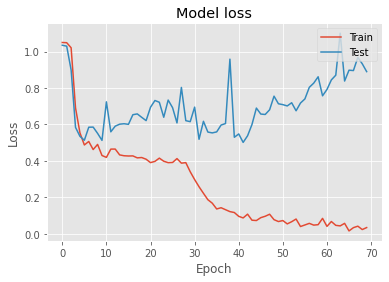

In [ ]:
# Plot train vs test loss during training
plot_loss(history.history['loss'], history.history['val_loss'])

### Plot Accuracy

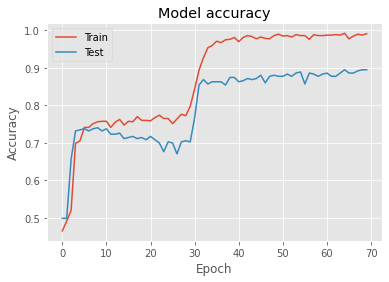

In [ ]:
plot_accuracy(history.history['accuracy'], history.history['val_accuracy'])

## Apakah performa model meningkat jika lebih banyak data yang digunakan?

In [ ]:
initial_weights = model.get_weights()
train_accs = []
test_accs = []
training_sizes = [ 125,  502,  879, 1255]
early_stop = EarlyStopping(monitor = 'loss', patience = 1)

In [ ]:
for size in training_sizes:
  	# Get a fraction of training data (we only care about the training data)
    X_train_frac, y_train_frac = X_train[:size], y_train[:size]

    # Reset the model to the initial weights and train it on the new training data fraction
    model.set_weights(initial_weights)
    model.fit(X_train_frac, y_train_frac, epochs = 50, callbacks = [early_stop], verbose = 0)

    # Evaluate and store both: the training data fraction and the complete test set results
    train_accs.append(model.evaluate(X_train, y_train)[1])
    test_accs.append(model.evaluate(X_test, y_test)[1])

11/11 [==============================] - 0s 9ms/step - loss: 1.0654 - accuracy: 0.9184


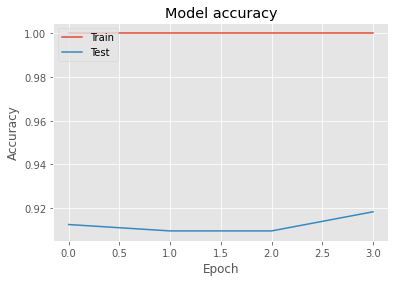

In [ ]:
# Plot train vs test accuracies
plot_accuracy(train_accs, test_accs)

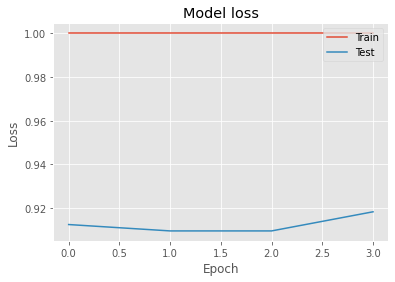

In [ ]:
plot_loss(train_accs, test_accs)

Sepertinya jumlah data yang digunakan tidak terlalu berpengaruh pada model yang digunakan